In [ ]:
from tensorflow.keras.layers import RepeatVector, Permute
from tensorflow.keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from tensorflow.keras.layers import BatchNormalization, RepeatVector, Permute
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

In [ ]:
# !pip install scikit-image

In [ ]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
trainimg = []
for filename in os.listdir('images/Train/'):
      trainimg.append(img_to_array(Image.open('images/Train/'+filename).resize((256,256))))

In [ ]:
trainimg = np.array(trainimg, dtype=float)
Xtrain = 1.0/255*trainimg

**Free some Memory**

In [ ]:
del trainimg

**Training model**

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse')

datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

batch_size = 50
def sep_l_a_b(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

model.fit_generator(sep_l_a_b(batch_size), epochs=1, steps_per_epoch=5000, callbacks = [checkpoint])

**Load and test model**

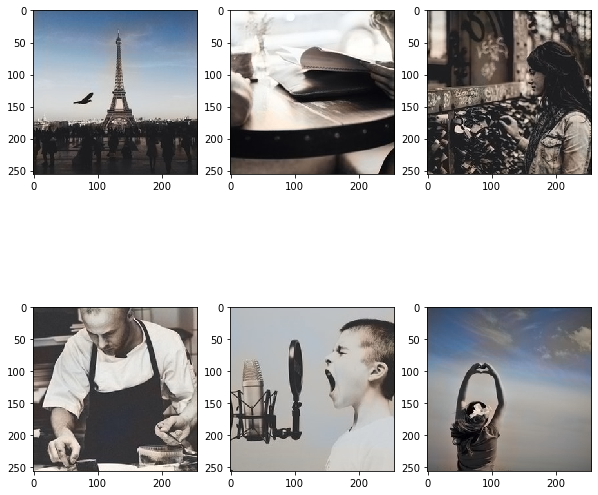

In [15]:
model.load_weights('weights.hdf5')

#Load test images
test_images = []
for filename in os.listdir('Test/'):
    if filename != '.ipynb_checkpoints':
        test_images.append(img_to_array(load_img('Test/'+filename)))
test_images = np.array(test_images, dtype=float)
test_images = rgb2lab(1.0/255*test_images)[:,:,:,0]
test_images = test_images.reshape(test_images.shape+(1,))

pred_imgs = model.predict(test_images)
pred_imgs = pred_imgs * 128

f, ax = plt.subplots(2,3)
f.set_figheight(10)
f.set_figwidth(10)
c = 0
for i in range(2):
    for j in range(3):       
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = test_images[c][:,:,0]
        cur[:,:,1:] = pred_imgs[c]
        ax[i][j].imshow(lab2rgb(cur))
        c = c + 1